In [1]:
#!/bin/bash
!curl -L -o libri-noise-dataset.zip https://www.kaggle.com/api/v1/datasets/download/earth16/libri-speech-noise-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6178M  100 6178M    0     0   271M      0  0:00:22  0:00:22 --:--:--  291M


In [2]:
!unzip -q libri-noise-dataset.zip

In [3]:
!rm -rf BWAVN.7z epoc-27-results.xltx LibriNoise_Train_Test_NPY ModelArchitecture.txt model.h5.png noisesB.7z NoiseTest.pptx NoiseTest_SNR.pptx results.7z

In [4]:
!7z x train.7z -onoisy > /dev/null

In [5]:
!7z x y_train.7z -odenoised > /dev/null

In [6]:
!7z x test.7z -onoisy > /dev/null
!7z x y_test.7z -odenoised > /dev/null

In [7]:
# !pip install complextorch

In [8]:
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio, IFrame, display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [9]:
!ls noisy/train/103-1240-0005.wav

noisy/train/103-1240-0005.wav


In [10]:
!ls denoised/

y_test	y_train


In [11]:
train_noisy_files = sorted(glob.glob('noisy/train/*.wav'))
train_clear_files = sorted(glob.glob('denoised/y_train/*.wav'))
assert len(train_clear_files) == len(train_noisy_files)

In [12]:
train_noisy_files[0], train_clear_files[0]

('noisy/train/103-1240-0005.wav', 'denoised/y_train/103-1240-0005.wav')

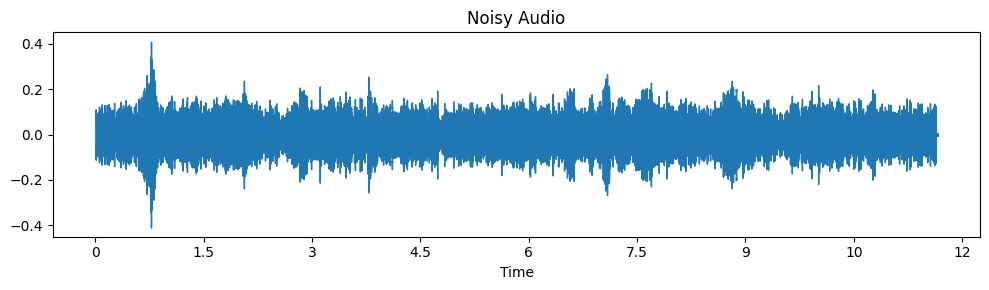

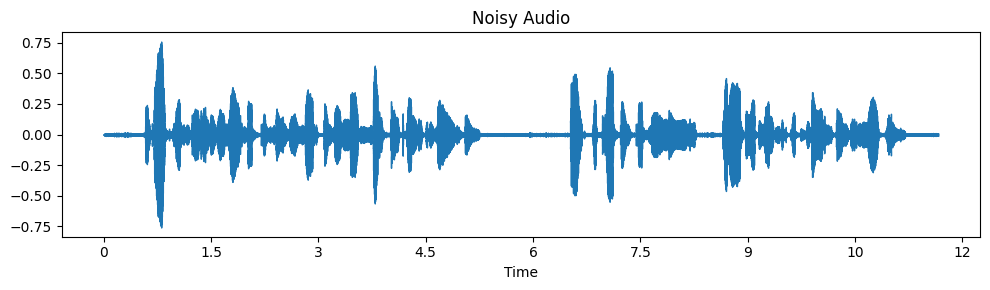

In [13]:
sr = 16000

idx = 1000

x, sr = librosa.load(train_noisy_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(x,rate=sr))

y, sr = librosa.load(train_clear_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(y,rate=sr))

In [14]:
import glob
import librosa
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import random

def tensor_to_sftf(arr):
    n_fft = 512
    hop_length = n_fft // 4   # 128
    win_length = n_fft        # 512
    window = torch.hann_window(win_length)

    return torch.stft(arr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)

class MyDataset(Dataset):
    def __init__(self, noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', ind=None, need_crop=False, cnt_seconds=16, need_all=False, single_file_path=None):
        if (single_file_path is not None):
            self.noisy_files = [single_file_path]
            self.clear_files = [single_file_path]
        else:
            self.noisy_files = np.array(sorted(glob.glob(noisy_folder + '*.wav')))
            self.clear_files = np.array(sorted(glob.glob(denoised_folder + '*.wav')))
        # print(len(self.clear_files))

        assert len(self.noisy_files) == len(self.clear_files)
        for f, s in zip(self.noisy_files, self.clear_files):
            assert f.split('/')[-1] == s.split('/')[-1]

        if ind is not None:
            self.noisy_files = self.noisy_files[ind]
            self.clear_files = self.clear_files[ind]
        self.cnt_seconds = cnt_seconds
        self.sr = 16000
        self.need_crop = need_crop
        self.need_all = need_all
            
    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        need_size = self.cnt_seconds * self.sr
        
        noisy_file = self.noisy_files[idx]
        clear_file = self.clear_files[idx]

        noisy_arr, _ = librosa.load(noisy_file, mono=True, sr=self.sr, offset=0)
        clear_arr, _ = librosa.load(clear_file, mono=True, sr=self.sr, offset=0)

        noisy_arr = torch.tensor(noisy_arr, dtype=torch.float)
        clear_arr = torch.tensor(clear_arr, dtype=torch.float)

        if self.need_all:
            noisy_segments = []
            clear_segments = []

            num_segments = max(len(noisy_arr) // need_size, 1)
            for i in range(num_segments):
                start = i * need_size
                noisy_segments.append(noisy_arr[start:start + need_size])
                clear_segments.append(clear_arr[start:start + need_size])

            noisy_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in noisy_segments]
            clear_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in clear_segments]

            # noisy_segments = []
            noisy_segments = [tensor_to_sftf(cur) for cur in noisy_segments]
            # clear_segments = [tensor_to_sftf(cur) for cur in clear_segments]
            
            return (torch.stack(noisy_segments).unsqueeze(1), torch.stack(clear_segments).unsqueeze(1))

        if not self.need_crop:
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))
        else:
            l = random.randint(0, max(1, noisy_arr.shape[0] - need_size))
            r = min(l + need_size, noisy_arr.shape[0])
            noisy_arr = noisy_arr[l:r]
            clear_arr = clear_arr[l:r]
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))

        assert noisy_arr.shape == clear_arr.shape

        # print(noisy_arr.shape)
        # noisy_stft = torch.tensor(librosa.stft(noisy_arr.numpy())).unsqueeze(0)
        # clear_stft = torch.tensor(librosa.stft(clear_arr.numpy())).unsqueeze(0)
        noisy_stft = tensor_to_sftf(noisy_arr).unsqueeze(0)
        # clear_stft = tensor_to_sftf(clear_arr).unsqueeze(0)
        clear_arr = clear_arr.unsqueeze(0)

        return (noisy_stft, clear_arr)


In [15]:

n_total = 7000
cnt_valid = 400
all_indices = list(range(n_total))

random.seed(42)
random.shuffle(all_indices)
valid_indices = np.array(all_indices[:cnt_valid])
train_indices = np.array(all_indices[cnt_valid:])

train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=False, ind=train_indices)
valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=True, ind=valid_indices)
test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=4, need_all=True)

# train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=2, need_all=False, ind=train_indices)
# valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=2, need_all=True, ind=valid_indices)
# test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=2, need_all=True)

In [16]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6600, 400, 105)

In [17]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [18]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 257, 501]), torch.Size([1, 64000]))

In [19]:
def pad_or_trim_2d(x, ref):
    """
    Make x’s spatial dims match ref’s spatial dims by
    zero‑padding or trimming on the right/bottom.
    x: [B, C, Hx, Wx]
    ref: [B, C_ref, Hr, Wr]
    Returns: x’ of shape [B, C, Hr, Wr]
    """
    Hr, Wr = ref.size(2), ref.size(3)
    Hx, Wx = x.size(2),   x.size(3)

    # pad/trim height
    dh = Hr - Hx
    if dh > 0:
        x = F.pad(x, (0, 0, 0, dh))
    elif dh < 0:
        x = x[:, :, :Hr, :]

    dw = Wr - x.size(3)
    if dw > 0:
        x = F.pad(x, (0, dw, 0, 0))
    elif dw < 0:
        # trim right
        x = x[:, :, :, :Wr]

    return x


class UModel(nn.Module):
    def make_ds_conv_block(self, idx):
        in_channels = (1 if idx == 1 else self.F_c*(idx-1))
        padd = (self.f_d//2 if isinstance(self.f_d, int) else [self.f_d[0] // 2, self.f_d[1] // 2])
        out_channels = self.F_c * idx
        return [
                    nn.Conv2d(in_channels, out_channels, kernel_size=self.f_d, padding=padd),
                    nn.Conv2d(in_channels, out_channels, kernel_size=self.f_d, padding=padd),
                    nn.BatchNorm2d(out_channels),
                    nn.BatchNorm2d(out_channels),
                    nn.AvgPool2d(kernel_size=2),
                    nn.PReLU(),
                ]

    def make_us_conv_block(self, idx):
        in_channels = self.F_c * idx * 2
        out_channels = (self.k if idx == 1 else self.F_c * (idx - 1))
        if (idx > 1):
            return [
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.BatchNorm2d(out_channels),
                        nn.BatchNorm2d(out_channels),
                        nn.PReLU(),
                   ]
        else:
            return [
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.BatchNorm2d(out_channels),
                        nn.BatchNorm2d(out_channels),
                        nn.Tanh(),
                   ]

    def apply_complex_conv(self, X_r, X_i, conv_r, conv_i):
        y_r = conv_r(X_r) - conv_i(X_i)
        y_i = conv_i(X_r) + conv_r(X_i)
        return y_r, y_i

    def apply_complex_norm(self, X_r, X_i, norm_r, norm_i):
        y_r = norm_r(X_r)
        y_i = norm_i(X_i)
        return y_r, y_i
    
    def apply_complex_func(self, X_r, X_i, func):
        y_r = func(X_r)
        y_i = func(X_i)
        return y_r, y_i
    
    def apply_ds_block(self, X_r, X_i, block):
        X_r, X_i = self.apply_complex_conv(X_r, X_i, block[0], block[1])
        X_r, X_i = self.apply_complex_norm(X_r, X_i, block[2], block[3])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[4])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[5])
        return X_r, X_i

    def apply_us_block(self, X_r, X_i, block):
        X_r, X_i = self.apply_complex_conv(X_r, X_i, block[0], block[1])
        X_r, X_i = self.apply_complex_norm(X_r, X_i, block[2], block[3])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[4])
        # X = self.apply_complex_func(X, block[5])
        return X_r, X_i
        
    def __init__(self, L, F_c, f_d, f_u, k):
        super().__init__()
        self.L = L
        self.F_c = F_c
        self.f_d = f_d
        self.f_u = f_u
        self.k = k
        
        self.ds_conv_blocks = []
        for i in range(1, L + 1):
            self.ds_conv_blocks.append(nn.ModuleList(self.make_ds_conv_block(i)))

        self.back_bone = nn.ModuleList([
            nn.GRU(input_size=288, hidden_size=288,num_layers=2, batch_first=True),
            nn.GRU(input_size=288, hidden_size=288,num_layers=2, batch_first=True)
        ]) ## bidirectional??
        self.us_conv_blocks = [None] * L
        for i in range(1, L + 1, 1):
             self.us_conv_blocks[i - 1] = nn.ModuleList(self.make_us_conv_block(i))

        self.ds_conv_blocks = nn.ModuleList(self.ds_conv_blocks)
        self.us_conv_blocks = nn.ModuleList(self.us_conv_blocks)

    def apply_complex_lstm(self, X_r, X_i, lstm_r, lstm_i):
        y_r = lstm_r(X_r)[0] - lstm_i(X_i)[0]
        y_i = lstm_r(X_i)[0] + lstm_i(X_r)[0]
        return y_r, y_i

    def forward(self, X_r, X_i):
        
        ds_tensors = []
        ds_tensors.append((X_r, X_i))
        for i in range(1, self.L + 1):
            X_r, X_i = self.apply_ds_block(X_r, X_i, self.ds_conv_blocks[i - 1])
            ds_tensors.append((X_r, X_i))

        assert X_r.shape == X_i.shape
        # B x C x H x W
        
        # print(X_r.shape, X_i.shape)
        h, w = X_r.shape[2], X_r.shape[3]
        X_r = X_r.reshape(X_r.shape[0], X_r.shape[1], -1).permute(0, 2, 1)
        X_i = X_i.reshape(X_i.shape[0], X_i.shape[1], -1).permute(0, 2, 1)
        # B x H*W x C
        X_r,X_i = self.apply_complex_lstm(X_r, X_i, self.back_bone[0], self.back_bone[1])
        # print(X_r.shape, X_i.shape)
        X_r = X_r.permute(0, 2, 1)
        X_i = X_i.permute(0, 2, 1)
        # print(X_r.shape, X_i.shape)
        X_r = X_r.reshape(X_r.shape[0], X_r.shape[1], h, w)
        X_i = X_i.reshape(X_i.shape[0], X_i.shape[1], h, w)
        
        # B x C x H x W
        # C = L * F_c

        for i in range(self.L, 0, -1):
            skip_r, skip_i = ds_tensors[i]
            
            X_r = pad_or_trim_2d(X_r, skip_r)
            X_i = pad_or_trim_2d(X_i, skip_i)
            # print(X_r.shape, skip_r.shape)
            
            # del skip
            # break                 
            new_X_r = torch.concat((X_r, skip_r), dim=1)
            new_X_i = torch.concat((X_i, skip_i), dim=1)
            X_r,X_i = self.apply_us_block(new_X_r, new_X_i, self.us_conv_blocks[i - 1])

        # print(X.shape, ds_tensors[0].shape)
        X_r = pad_or_trim_2d(X_r, ds_tensors[0][0])
        X_i = pad_or_trim_2d(X_i, ds_tensors[0][1])
        return X_r, X_i

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UModel(L=6, F_c=48, f_d=[13, 2], f_u=5, k=1).to(device)
model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'], output_device=0) # cant parralel??
# because of complex numbers, need to move complex to 2 channels

In [20]:
for cur,_ in train_dataloader:
    cur = cur.to(device)
    print(cur.shape, cur.dtype)
    # cur = cur.unsqueeze(0)
    cur_ans_r, cur_ans_i = model(cur.real, cur.imag)
    cur_ans = torch.complex(cur_ans_r, cur_ans_i)
    print(cur_ans.shape)
    del cur_ans
    del cur_ans_r
    del cur_ans_i
    break

torch.Size([32, 1, 257, 501]) torch.complex64
torch.Size([32, 1, 257, 501])


In [21]:
!pip install asteroid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
!pip install pesq

In [23]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from pesq import pesq

2025-07-19 07:46:16.474368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752911176.865111      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752911176.975850      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
from torchmetrics.audio import PerceptualEvaluationSpeechQuality

In [25]:
def calculate_batch_SI_SDR(preds_batch, y_batch, SI_SDR_metric):
    sum_metric = 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        try:
            cur = SI_SDR_metric(cur_pred, cur_y)
            sum_metric += cur
        except:
            continue
    return sum_metric / len(preds_batch)

def calculate_batch_PESQ(preds_batch, y_batch, fs=16000, mode='wb'):
    total, count = 0.0, 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        ref = cur_y.squeeze(0).detach().cpu().numpy()
        deg = cur_pred.squeeze(0).detach().cpu().numpy()

        try:
            score = pesq(fs, ref=ref, deg=deg, mode=mode)
            total += score
            count += 1
        except:
            continue

    return total / count if count > 0 else 0.0

In [26]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

def from_sftf(X_r, X_i):
    # [B x 1 x H x W] -> [B x H x W]
    X_r = X_r.reshape(X_r.shape[0], X_r.shape[2], X_r.shape[3])
    X_i = X_i.reshape(X_i.shape[0], X_i.shape[2], X_i.shape[3])
    complex_spec = torch.complex(X_r, X_i)

    n_fft = 512
    hop_length = n_fft // 4   # 128
    win_length = n_fft        # 512
    window = torch.hann_window(win_length)
    
    wave = torch.istft(
        complex_spec,
        n_fft=n_fft,            # тот же N, что в stft
        hop_length=hop_length,
        win_length=win_length,
        window=window.to(device),
        center=True,
    )
    return wave.unsqueeze(1)

def train(model, criterion, train_dataloader, valid_dataset, optimizer, epochs, device, metrics):
    best_sdr = -1e6
    best_loss = 1e6

    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True, 
    ).to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0        

        cnt_steps_train = len(train_dataloader)
        for batch_x, batch_y in tqdm(train_dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            preds_r, preds_i = model(batch_x.real, batch_x.imag)
            preds = from_sftf(preds_r, preds_i)
            # print(preds.shape, real_ans.shape)

            # print(preds.shape, batch_y.shape)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()


        train_loss /= cnt_steps_train
        print(f'Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f}')

        metrics['train_loss'].append(train_loss)
        
        model.eval()
        valid_loss = 0
        valid_sdr = 0
        # valid_pesq = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(valid_dataset):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                # print(batch_x.shape, batch_y.shape)
                
                preds_r, preds_i = model(batch_x.real, batch_x.imag)
                preds = from_sftf(preds_r, preds_i)
                # real_ans = from_sftf(batch_y.real, batch_y.imag)

                
                loss = criterion(preds, batch_y)
                valid_loss += loss.item()
                
                valid_sdr += SI_SDR_metric(preds, batch_y).item()
                
                # valid_pesq += calculate_batch_PESQ(preds, batch_y)
                
        valid_loss /= len(valid_dataset)
        valid_sdr /= len(valid_dataset)
        # valid_pesq /= len(valid_dataset)
        

        print(f'Epoch {epoch}/{epochs} | Valid Loss: {valid_loss:.6f} | Valid SI-SDR: {valid_sdr:.4f}')
        
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_si_sdr'].append(valid_sdr)
        # metrics['valid_pesq'].append(valid_pesq)

        if valid_sdr > best_sdr:
            best_sdr = valid_sdr
            sdr_model = model
        if valid_loss < best_loss:
            best_loss = valid_loss
            loss_model = model
            
    return sdr_model, loss_model

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UModel(L=12, F_c=24, f_d=15, f_u=5, k=1).to(device)
model = UModel(L=6, F_c=48, f_d=[13, 2], f_u=5, k=1).to(device)

model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'])
# criterion = nn.MSELoss()

metrics = {
    'train_loss': [],
    'train_si_sdr': [],
    'train_pesq': [],
    'valid_loss': [],
    'valid_si_sdr': [],
    'valid_pesq': []
}


In [28]:
from asteroid.losses import SingleSrcPMSQE

In [29]:
def si_sdr_loss(pred, ref, eps=1e-8):
    # pred/ref shape: [B, 1, T]
    ref_energy = torch.sum(ref**2, dim=-1, keepdim=True) + eps
    proj = torch.sum(pred * ref, dim=-1, keepdim=True) * ref / ref_energy
    
    noise = pred - proj

    num = torch.sum(proj**2, dim=-1)
    den = torch.sum(noise**2, dim=-1)
    ratio = num / (den + eps)
    ratio = torch.clamp(ratio, min=eps)
    sisd = 10 * torch.log10(ratio)
    return -sisd.mean()


class SI_SDR_PESQ_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.pmsqe = SingleSrcPMSQE(sample_rate=16000).to(device)
        self.si_sdr_loss = si_sdr_loss
        
        self.n_fft = 512
        self.win_length = 512
        self.hop_length = 128
        self.window = torch.hann_window(self.win_length)

    def forward(self, preds, target):
        sdr_loss = self.si_sdr_loss(preds, target)

        preds1 = preds.squeeze(1) 
        target1 = target.squeeze(1)

        window = self.window.to(preds1.device)

        def mag_stft(x):
            stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
                              win_length=self.win_length, window=window,
                              return_complex=True)
            return torch.abs(stft) 

        preds_mag = mag_stft(preds1)
        target_mag = mag_stft(target1)

        pmsqe_loss = self.pmsqe(preds_mag, target_mag).mean()
        return sdr_loss + self.alpha * pmsqe_loss


# criterion = si_sdr_loss
criterion = SI_SDR_PESQ_Loss(0.7)

In [30]:
!cp /kaggle/input/si_sdr_dccrn_v2/pytorch/default/1/si_sdr_dccrn.pt .
model.module.load_state_dict(torch.load('si_sdr_dccrn.pt'))
!rm si_sdr_dccrn.pt

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [32]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 10, device, metrics)

100%|██████████| 207/207 [08:08<00:00,  2.36s/it]


Epoch 1/10 | Train Loss: -9.745658


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 1/10 | Valid Loss: -8.385129 | Valid SI-SDR: 9.4466


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 2/10 | Train Loss: -9.976201


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 2/10 | Valid Loss: -9.776271 | Valid SI-SDR: 10.6611


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 3/10 | Train Loss: -9.964398


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 3/10 | Valid Loss: -9.913313 | Valid SI-SDR: 10.7827


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 4/10 | Train Loss: -9.894757


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 4/10 | Valid Loss: -9.814670 | Valid SI-SDR: 10.6871


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 5/10 | Train Loss: -10.009314


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 5/10 | Valid Loss: -9.730434 | Valid SI-SDR: 10.6291


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 6/10 | Train Loss: -10.026772


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


Epoch 6/10 | Valid Loss: -9.960162 | Valid SI-SDR: 10.8095


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 7/10 | Train Loss: -10.040969


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 7/10 | Valid Loss: -8.384856 | Valid SI-SDR: 9.4910


100%|██████████| 207/207 [08:11<00:00,  2.38s/it]


Epoch 8/10 | Train Loss: -10.061601


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 8/10 | Valid Loss: -9.950307 | Valid SI-SDR: 10.8161


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 9/10 | Train Loss: -10.097808


100%|██████████| 400/400 [00:40<00:00,  9.91it/s]


Epoch 9/10 | Valid Loss: -10.115006 | Valid SI-SDR: 10.9322


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 10/10 | Train Loss: -9.959821


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]

Epoch 10/10 | Valid Loss: -7.961230 | Valid SI-SDR: 9.0627


In [33]:
model = best_loss

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [35]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 10, device, metrics)

100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 1/10 | Train Loss: -10.298580


100%|██████████| 400/400 [00:40<00:00,  9.78it/s]


Epoch 1/10 | Valid Loss: -10.056584 | Valid SI-SDR: 10.9012


100%|██████████| 207/207 [08:11<00:00,  2.38s/it]


Epoch 2/10 | Train Loss: -10.405002


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 2/10 | Valid Loss: -10.487111 | Valid SI-SDR: 11.2375


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 3/10 | Train Loss: -10.468654


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 3/10 | Valid Loss: -10.470307 | Valid SI-SDR: 11.2548


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 4/10 | Train Loss: -10.429231


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 4/10 | Valid Loss: -10.362432 | Valid SI-SDR: 11.1576


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 5/10 | Train Loss: -10.432552


100%|██████████| 400/400 [00:40<00:00,  9.87it/s]


Epoch 5/10 | Valid Loss: -10.267849 | Valid SI-SDR: 11.0569


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 6/10 | Train Loss: -10.478755


100%|██████████| 400/400 [00:41<00:00,  9.75it/s]


Epoch 6/10 | Valid Loss: -10.523868 | Valid SI-SDR: 11.2884


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 7/10 | Train Loss: -10.548347


100%|██████████| 400/400 [00:40<00:00,  9.79it/s]


Epoch 7/10 | Valid Loss: -10.569109 | Valid SI-SDR: 11.3217


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 8/10 | Train Loss: -10.561209


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Epoch 8/10 | Valid Loss: -10.517213 | Valid SI-SDR: 11.2899


100%|██████████| 207/207 [08:11<00:00,  2.37s/it]


Epoch 9/10 | Train Loss: -10.566189


100%|██████████| 400/400 [00:40<00:00,  9.96it/s]


Epoch 9/10 | Valid Loss: -9.928521 | Valid SI-SDR: 10.7892


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 10/10 | Train Loss: -10.574146


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]

Epoch 10/10 | Valid Loss: -10.494837 | Valid SI-SDR: 11.2654


In [36]:
model = best_loss

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['valid_si_sdr'], label='Validation SI-SDR', marker='o')
    plt.title('Training and Validation SDR')
    plt.xlabel('Epochs')
    plt.ylabel('SI-SDR')
    plt.legend()
    plt.grid()



    plt.tight_layout()
    plt.show()


In [38]:
# metrics['train_si_sdr'] = [cur.item() for cur in metrics['train_si_sdr']]
# metrics['valid_si_sdr'] = [cur.item() for cur in metrics['valid_si_sdr']]

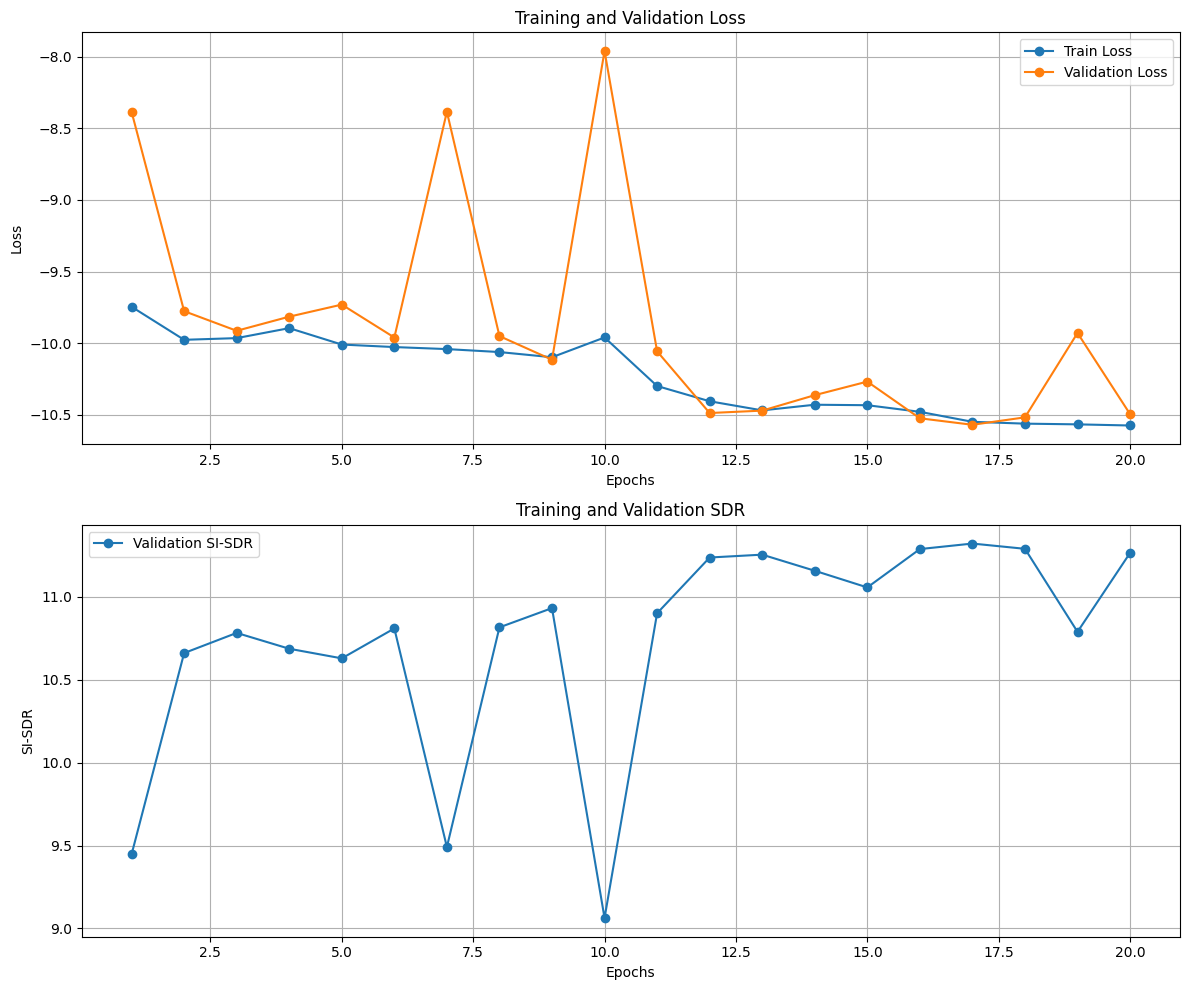

In [39]:
plot_metrics(metrics)

In [40]:
model = best_loss

In [41]:
def evaluate_test(model, test_dataset, device, criterion):
    model.eval()
    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,  
    ).to(device)
    loss = 0
    si_sdr = 0
    pesq = 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataset):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds_r, preds_i = model(batch_x.real, batch_x.imag)
            preds = from_sftf(preds_r, preds_i)

            loss += criterion(preds, batch_y)
            si_sdr += SI_SDR_metric(preds, batch_y)
            pesq += calculate_batch_PESQ(preds, batch_y)
    loss /= len(test_dataset)
    si_sdr /= len(test_dataset)
    pesq /= len(test_dataset)
    print(f'Test Loss: {loss}, Test SI-SDR: {si_sdr}, Test PESQ: {pesq}')

In [42]:
def denoise_file(path, model, device, cnt_seconds=16):
    sr = 16000
    noise_arr,_ = librosa.load(path, mono=True, sr=sr, offset=0, duration=16)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(noise_arr, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(noise_arr,rate=sr))

    with torch.no_grad():
        cur_dataset = MyDataset(need_crop=True, cnt_seconds=cnt_seconds, need_all=True, single_file_path=path)

        X = cur_dataset[0][0]
        clear_audio_r, clear_audio_i = model(X.real, X.imag)
        clear_audio = from_sftf(clear_audio_r, clear_audio_i)
        
        clear_audio = clear_audio.detach().cpu().numpy()
        clear_audio = clear_audio.reshape(-1)
    # print(clear_audio.shape)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(clear_audio, sr=sr, axis='time')
    plt.title("Clear Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(clear_audio,rate=sr))

In [43]:
evaluate_test(model, test_dataset, device, criterion)

100%|██████████| 105/105 [01:12<00:00,  1.46it/s]

Test Loss: -10.0426607131958, Test SI-SDR: 10.785832405090332, Test PESQ: 1.676874849058333


In [44]:
torch.save(model.module.state_dict(), 'model.pt')

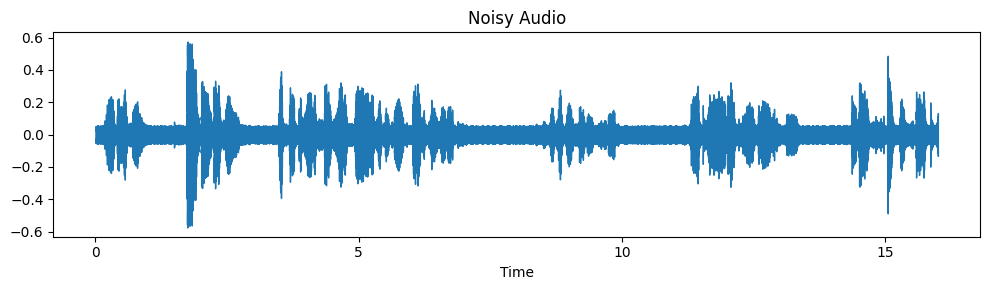

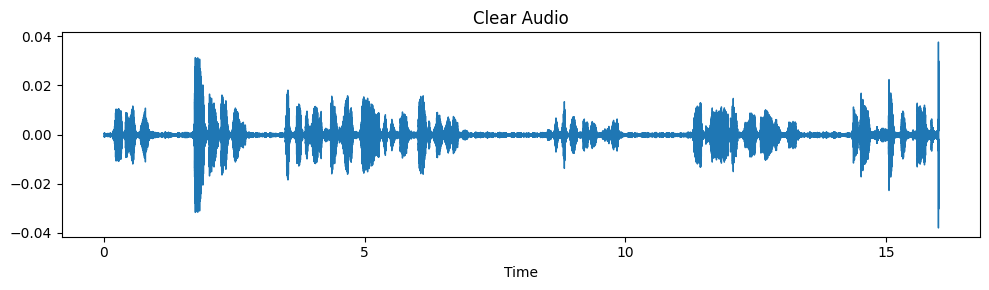

In [45]:
denoise_file('noisy/test/1034-121119-0049.wav', model, device)

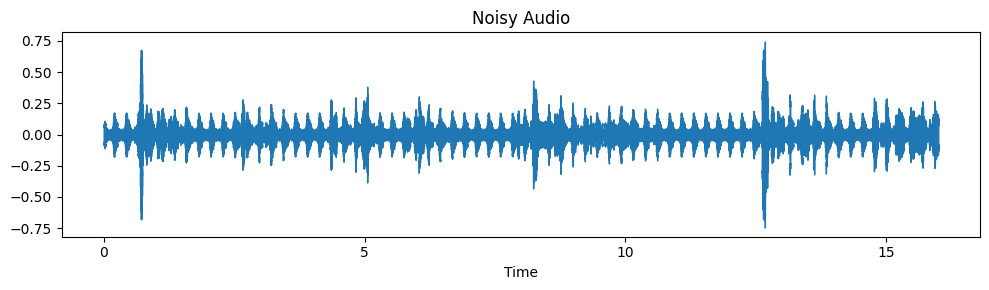

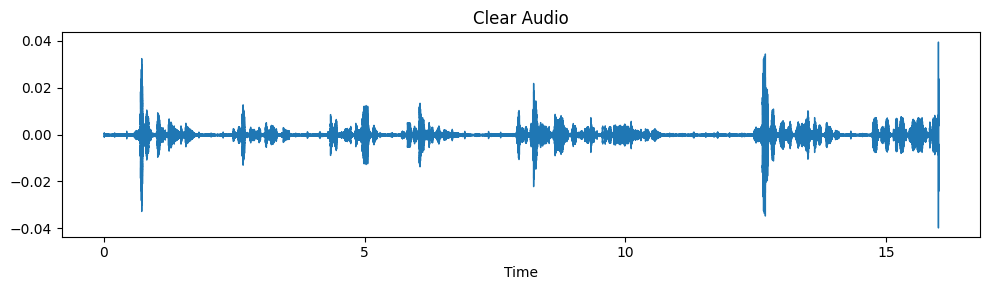

In [46]:
denoise_file('noisy/test/1040-133433-0080.wav', model, device)

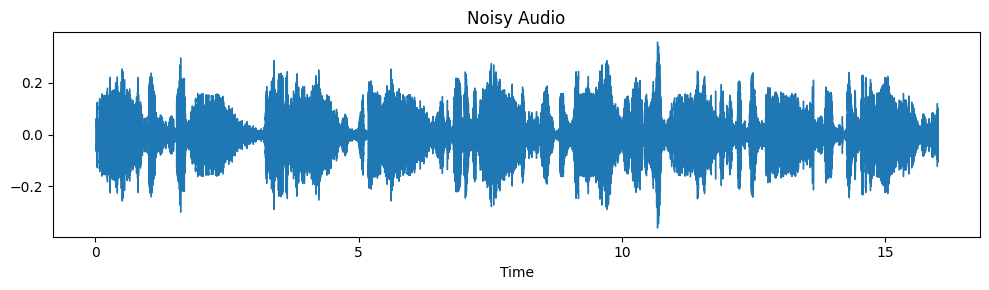

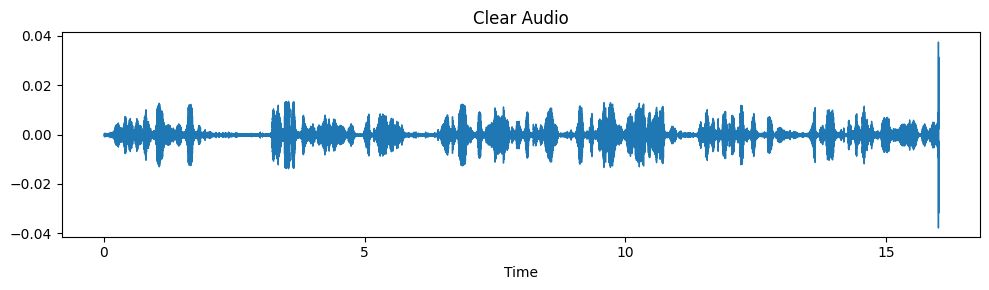

In [47]:
denoise_file('noisy/test/1081-125237-0053.wav', model, device)

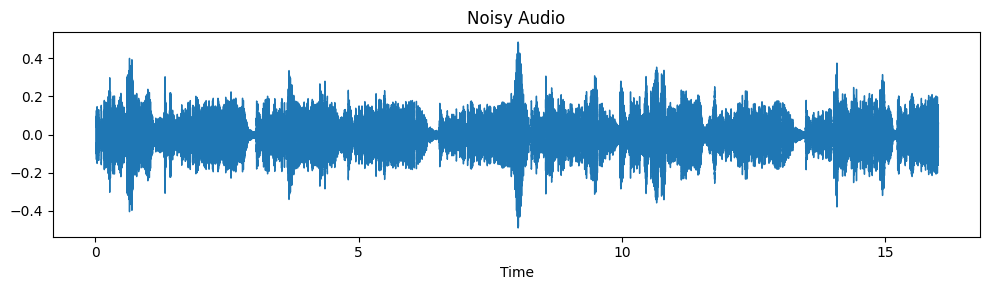

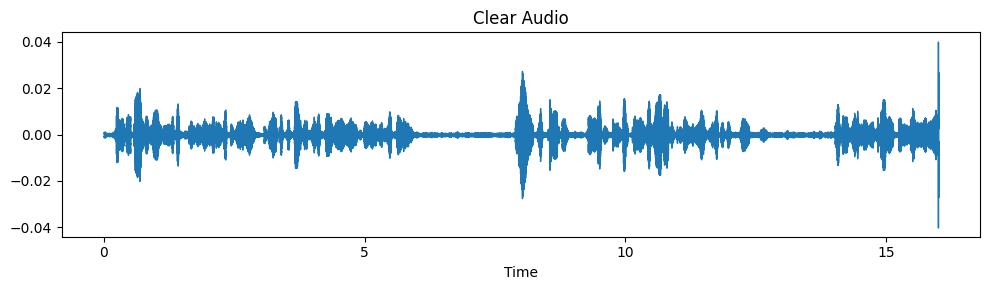

In [48]:
denoise_file('noisy/test/226-131532-0003.wav', model, device)

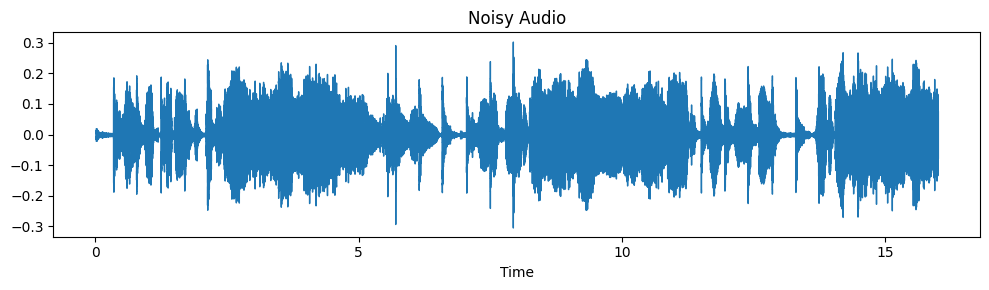

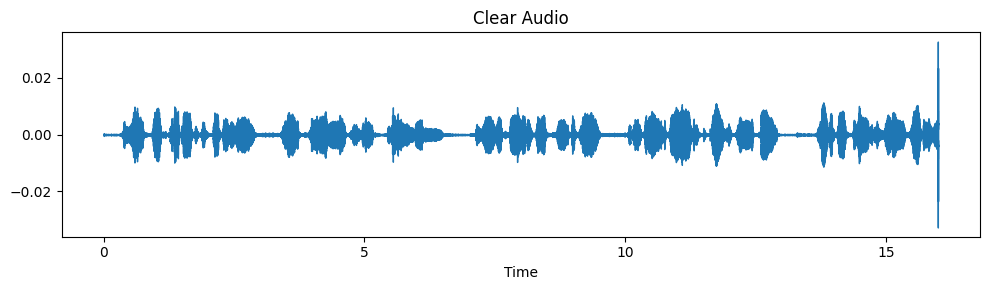

In [49]:
denoise_file('noisy/test/6848-252323-0032.wav', model, device)

In [50]:
!rm -rf denoised libri-noise-dataset.zip noisy samples.7z test.7z train.7z y_test.7z y_train.7z

In [51]:
!ls

model.pt  __notebook__.ipynb
